# 3D spectral analysis of HESS J1745-290 (with HAP-hd)

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [117]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [133]:
from pathlib import Path

# General path (to select which analysis/set of data we work with)
path = Path("../../../hess_results/GC_variability_0.18.2/hap-hd")
path.mkdir(exist_ok=True)

pathma = Path(path/"mapdatasets")
pathma.mkdir(exist_ok=True)

# To find the model template
pathm = Path(path/"models")
pathm.mkdir(exist_ok=True)

model_name = pathm/"models_template_2cutoff_DE3comp.yaml"

# Directory for outputs
path3d = Path(path/"3Dspectra")
path3d.mkdir(exist_ok=True)

In [119]:
pathtry = Path(path3d/"2amps_2indexes_1cutoff_DE3comp")
pathtry.mkdir(exist_ok=True)

pathFP = Path(pathtry/"fluxpoints")
pathFP.mkdir(exist_ok=True)

In [120]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

## Creating the geometry

In [121]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

## The mask

In [122]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 3*u.deg)

#éventuellement étendre le masque

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.75 * u.deg)

mask_fit = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

mask_fit = Map.from_geom(geom, data=mask_fit)

## Useful functions

In [123]:
def fit_dataset(dataset, models):

    dataset.mask_fit = mask_fit
    dataset.models =  models
    bkg_model = FoVBackgroundModel(dataset_name = dataset.name)

    fit = Fit([dataset])
    result = fit.run()
    
    table = result.parameters.to_table()

    models_fitted = dataset.models.copy()
    
    return fit, result, models_fitted


def fit_joint_datasets(datasets, models):

    for dataset in datasets:
        dataset.mask_fit = mask_fit
        dataset.models =  models
        bkg_model = FoVBackgroundModel(dataset_name = dataset.name)

    fit = Fit(datasets)
    result = fit.run()
    
    table = result.parameters.to_table()

    models_fitted = datasets[0].models.copy()
    
    return fit, result, models_fitted

In [124]:
def plot_spectrum(models, path ,namefile, name):
    plt.figure(figsize=(12,8))
    plot_kwargs = {
        "energy_range": [0.1, 30] * u.TeV,
        "energy_power": 2,
        "flux_unit": "erg-1 cm-2 s-1",
    }

    ## central source
    index = models[0].spectral_model.parameters["index"].value
    amp = models[0].spectral_model.parameters["amplitude"].value
    
    if models[0].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[0].spectral_model.parameters["lambda_"].value
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff))
    else :  
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[0].spectral_model.plot_error(**plot_kwargs)

    
    ## diffuse model
    index = models[2].spectral_model.parameters["index"].value
    amp = models[2].spectral_model.parameters["amplitude"].value
    
    if models[2].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[2].spectral_model.parameters["lambda_"].value
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse   : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, cutoff ))
    else :  
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse   : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[2].spectral_model.plot_error(**plot_kwargs)

    plt.title("Spectral models fitted for a constant GC source (" + name + ")")
    plt.legend()
    plt.savefig(path/namefile)

In [125]:
def FluxPointsFitting(datasets, num, e_edges, namefile):
    # this function has to be given the number of the source model in case of multiple models
    # more parameters exist to initialise the estimator
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source =num) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset.models[num])
    plt.figure(figsize=(8, 6))
    flux_points_dataset.plot_fit()
    name = "fluxpoints_"+namefile+".pdf"
    plt.savefig(pathFP/name)
    

In [126]:
def DoubleFluxPointsFitting(datasets, e_edges):
    # computes source flux points and DE flux points at once, without the residuals thingy
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source = 0) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset_GC = FluxPointsDataset(data=flux_points, models=datasets.models[0])
    
    
    ## diffuse model
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source = 2) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset_DE = FluxPointsDataset(data=flux_points, models=datasets.models[2])

    return flux_points_dataset_GC, flux_points_dataset_DE
    
    
    
def DoubleFluxPointsPlotting(FPdatasetsGC, FPdatasetsDE, namefile, name):
    # plots source flux points and DE flux points at once, without the residuals thingy
    
    plt.figure(figsize=(10,8))

    index = FPdatasetsGC.models.parameters["index"].value
    amp = FPdatasetsGC.models.parameters["amplitude"].value
    
    if FPdatasetsGC.models.parameters["lambda_"].value != 0:
        cutoff = 1/FPdatasetsGC.models.parameters['lambda_'].value
        label_modelGC = {"label" : f"HESS J1745-290 : index = {index:03.3f} , amplitude = {10**12*amp:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {cutoff:03.3f} TeV"}
    else :  
        label_modelGC = {"label" : r"HESS J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp )}

    
    ## diffuse model
    
    index = FPdatasetsDE.models.parameters["index"].value
    amp = FPdatasetsDE.models.parameters["amplitude"].value
    
    if FPdatasetsDE.models.parameters["lambda_"].value != 0:
        cutoff = 1/FPdatasetsDE.models.parameters["lambda_"].value
        label_modelDE = {"label" : f"diffuse   : index = {index:03.3f} , amplitude = {10**12*amp:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {cutoff:03.3f} TeV"}
    else :  
        label_modelDE = {"label" : r"diffuse   : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp )}

    FPdatasetsGC.plot_spectrum( kwargs_fp = {"label":"HESS J1745-290 flux points"}, kwargs_model = label_modelGC)
    FPdatasetsDE.plot_spectrum( kwargs_fp = {"label":"DE flux points"}, kwargs_model = label_modelDE)
    
    plt.title("Spectral models and flux points (" + name + ")")
    plt.legend()
    name = "fluxpoints_"+namefile+".pdf"
    plt.savefig(pathFP/name)

In [143]:
def residuals(dataset, namefile, namefig,vmax=4):
    region = CircleSkyRegion(center=src_pos, radius=0.5 * u.deg)

    kwargs_spatial = {'vmin':-vmax, 'vmax':vmax } # nécessaire ?

    kwargs_spectral = {'method':'diff/sqrt(model)', 'region' : CircleSkyRegion(center=src_pos, radius=0.3 * u.deg)}
    
    dataset.plot_residuals(kwargs_spatial=kwargs_spatial, kwargs_spectral=kwargs_spectral)
    #plt.plot((0,0), '*')
    plt.title("residuals (diff/sqrt(model)) " + namefig)
    name = "residuals_" + namefile +"_hd.pdf"
    plt.savefig(pathtry/name, overwrite=True)

In [128]:
from scipy.stats import norm


def significance(dataset, namefile, namefig):
    plt.figure(figsize=(10,6))

    lima_estimator = ExcessMapEstimator("0.1 deg", selection_optional=[] , apply_mask_fit=True )
    
    res =  lima_estimator.run(dataset)
    
    res['sqrt_ts'].cutout(position=src_pos, width=(5 * u.deg, 3.5* u.deg)).plot(add_cbar=True)
    #plt.plot((0,0), '*')
    
    namepdf = "significance_"+namefile+"_hd.pdf"
    namefits = "significance_"+namefile+"_hd.fits"
    
    plt.title("Significance map (data v. predictions) "+namefig)
    
    plt.savefig(pathtry/namepdf, overwrite=True)
    res['sqrt_ts'].write(pathtry/namefits, overwrite=True)
    
    
    plt.figure(figsize=(8,6))
    signidata = res['sqrt_ts'].data#.cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    # on masque la région en bas à droite
    #mask = mask_fit.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    signidata_masked = signidata[0]#,mask]
    
    plt.hist(signidata_masked.flatten(),30, histtype='step', density=True)
    
    # what about cutting values above 5/below -5 ?
    x = np.abs(signidata_masked) < 5
    mean,std=norm.fit(signidata_masked[x])
    
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    y2= norm.pdf(x, 0, 1)   
    plt.plot(x, y2 ,label=r'$\mu$ = 0, $\sigma$ = 1')
    
    plt.legend()
    
    name = "significance_hist_"+namefile+"_hd.pdf"
    plt.title("Significance distribution "+namefig)
    plt.savefig(pathtry/name, overwrite=True)

In [159]:
# Creating the total dataset (potentially useless)

dataset_stacked = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

filename = "mapdataset_tot.fits.gz"
dataset_stacked = MapDataset.read(pathma/filename)

In [160]:
dataset_period = Datasets.read(pathma/"datasets_period.yaml")

## Reading the model template

In [161]:
modelGC,modelG09, model_diff_DGC, model_diff_CC, model_diff_LSC  = Models.read(model_name)

## Setting which parameters will vary

In [162]:
modelGC.parameters["index"].frozen = False
modelGC.parameters["index"].value = 1.971

modelGC.parameters["lon_0"].frozen = True
modelGC.parameters["lat_0"].frozen = True
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["reference"].frozen = True 

modelG09.parameters["index"].frozen = True
modelG09.parameters["lat_0"].frozen = True
modelG09.parameters["lon_0"].frozen = True
modelG09.parameters["amplitude"].frozen = False

In [163]:
# diffuse models
model_diff_DGC.parameters["index"].frozen = True
model_diff_DGC.parameters["index"].value = 2.3

model_diff_CC.parameters["index"].frozen = True
model_diff_CC.parameters["index"].value = 2.3

model_diff_LSC.parameters["index"].frozen = True
model_diff_LSC.parameters["index"].value = 2.3

model_diff_DGC.parameters["amplitude"].frozen = False
model_diff_DGC.parameters["reference"].frozen = True

model_diff_CC.parameters["amplitude"].frozen = False
model_diff_CC.parameters["reference"].frozen = True

model_diff_LSC.parameters["amplitude"].frozen = False
model_diff_LSC.parameters["reference"].frozen = True

In [164]:
# if there are cutoffs in the spectra

modelGC.parameters["lambda_"].frozen = False
modelGC.parameters["lambda_"].value = 1/8.732

model_diff_DGC.parameters["lambda_"].frozen = True
model_diff_DGC.parameters["lambda_"].value = 0.0


model_diff_CC.parameters["lambda_"].frozen = True
model_diff_CC.parameters["lambda_"].value = 0.0

model_diff_CC.parameters["lon_0"].frozen = True
model_diff_CC.parameters["lat_0"].frozen = True
model_diff_CC.parameters["sigma"].frozen = False


model_diff_LSC.parameters["lambda_"].frozen = True
model_diff_LSC.parameters["lambda_"].value = 0.0

model_diff_LSC.parameters["lon_0"].frozen = True
model_diff_LSC.parameters["lat_0"].frozen = True
model_diff_LSC.parameters["sigma"].frozen = False
model_diff_LSC.parameters["e"].frozen = True

# Fitting the many datasets

Stacking all three datasets tends to give poor results, trying to fit HESS1+2 on the one hand, and HESS1U on the other might be more succesful.

### Fitting the dataset for each period separately

In [165]:
%%time

models = modelGC.copy() + modelG09.copy()+ model_diff_DGC.copy()+ model_diff_CC.copy()+ model_diff_LSC.copy()

fit_hess1, result_hess1, models_hess1 = fit_dataset(dataset_period['hess1'], models)

name = "models_hess1_fitted.yaml"
models_hess1.write(pathtry/name, overwrite=True)

CPU times: user 4min 46s, sys: 1.75 s, total: 4min 48s
Wall time: 4min 48s


In [166]:
%%time

models = modelGC.copy() + modelG09.copy()+ model_diff_DGC.copy()+ model_diff_CC.copy()+ model_diff_LSC.copy()

fit_hess2, result_hess2, models_hess2 = fit_dataset(dataset_period['hess2'], models)

name = "models_hess2_fitted.yaml"
models_hess2.write(pathtry/name, overwrite=True)

CPU times: user 5min 37s, sys: 11.1 s, total: 5min 48s
Wall time: 5min 48s


In [167]:
%%time

models = modelGC.copy() + modelG09.copy()+ model_diff_DGC.copy()+ model_diff_CC.copy()+ model_diff_LSC.copy()

fit_hess1u, result_hess1u, models_hess1u = fit_dataset(dataset_period['hess1u'], models)

name = "models_hess1u_fitted.yaml"
models_hess1u.write(pathtry/name, overwrite=True)

CPU times: user 41.6 s, sys: 2.94 s, total: 44.5 s
Wall time: 44.5 s


In [172]:
result_hess1u

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 164
	total stat : 201899.31

### Fitting the joint dataset

In [156]:
%%time

models = modelGC.copy() + modelG09.copy()+ model_diff_DGC.copy()+ model_diff_CC.copy()+ model_diff_LSC.copy()

fit_joint, result_joint, models_joint = fit_joint_datasets(
    [dataset_period['hess1'], dataset_period['hess2'], dataset_period['hess1u']],
     models)

name = "models_joint_fitted.yaml"
models_joint.write(pathtry/name, overwrite=True)

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ast

CPU times: user 19min 55s, sys: 36.1 s, total: 20min 31s
Wall time: 20min 32s


In [158]:
result_joint

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 1713
	total stat : 627222.07

### Joint dataset without HESS1u

In [30]:
%%time

models = modelGC.copy() + modelG09.copy()+ model_diff_DGC.copy()+ model_diff_CC.copy()+ model_diff_LSC.copy()

fit_joint12, result_joint12, models_joint12 = fit_joint_datasets(
    [dataset_period['hess1'], dataset_period['hess2']],
     models)

name = "models_joint12_fitted.yaml"
models_joint12.write(pathtry/name, overwrite=True)

CPU times: user 15min 6s, sys: 13.5 s, total: 15min 19s
Wall time: 15min 20s


### Fitting the stacked dataset

In [152]:
%%time

models = modelGC.copy() + modelG09.copy()+ model_diff_DGC.copy()+ model_diff_CC.copy()+ model_diff_LSC.copy()

fit_stacked, result_stacked, models_stacked = fit_dataset(dataset_stacked, models)

name = "models_stacked_fitted.yaml"
models_stacked.write(pathtry/name, overwrite=True)

CPU times: user 9min 2s, sys: 1.93 s, total: 9min 4s
Wall time: 9min 5s


In [153]:
result_stacked

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 1748
	total stat : 133695.16

## Results

### Spectrum

In [116]:
plot_spectrum(models_hess1,  pathtry,"hess1_model_1cutoff_hd.pdf", "HESS1")
plot_spectrum(models_hess2,  pathtry,"hess2_model_1cutoff_hd.pdf", "HESS2")
plot_spectrum(models_hess1u,  pathtry,"hess1u_model_1cutoff_hd.pdf", "HESS1u")



plot_spectrum(models_joint,  pathtry,"joint_model_1cutoff_hd.pdf", "joint (all periods)")
plot_spectrum(models_joint12,  pathtry,"joint12_model_1cutoff_hd.pdf", "joint HESS1 + HESS2")

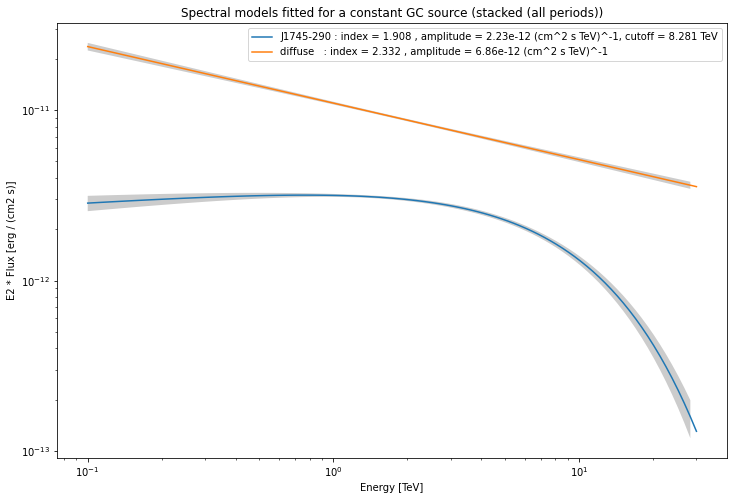

In [52]:
plot_spectrum(models_stacked,  pathtry,"stacked_model_1cutoff_hd.pdf", "stacked (all periods)")

## Flux points

In [27]:
e_min, e_max = 0.5, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

In [22]:
%%time

FPGC, DPDE = DoubleFluxPointsFitting(dataset_period, e_edges)

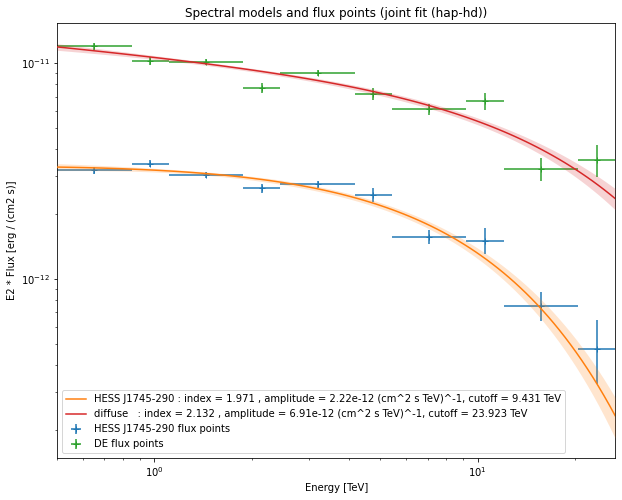

In [35]:
DoubleFluxPointsPlotting(FPGC, DPDE, "joint_2cutoff_hd", "joint fit (hap-hd)")

CPU times: user 3min 8s, sys: 31 s, total: 3min 39s
Wall time: 3min 39s


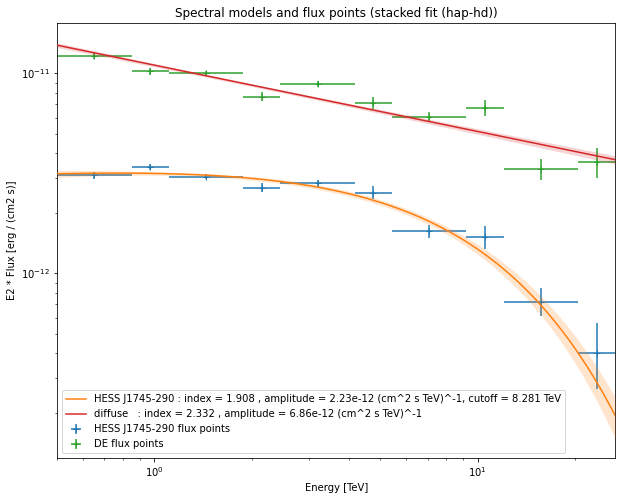

In [53]:
%%time

FPGC, DPDE = DoubleFluxPointsFitting(dataset_stacked, e_edges)

DoubleFluxPointsPlotting(FPGC, DPDE, "stacked_1cutoff_hd", "stacked fit (hap-hd)")

In [ ]:
DoubleFluxPointsFitting(dataset_period['hess1'], e_edges, "hess1_1cutoff_hd", "hess1 fit (hap-hd)")

In [ ]:
DoubleFluxPointsFitting(dataset_period['hess2'], e_edges, "hess2_1cutoff_hd", "hess2 fit (hap-hd)")

In [ ]:
DoubleFluxPointsFitting(dataset_period['hess1u'], e_edges, "hess1u_1cutoff_hd", "hess1u fit (hap-hd)")

## Maps

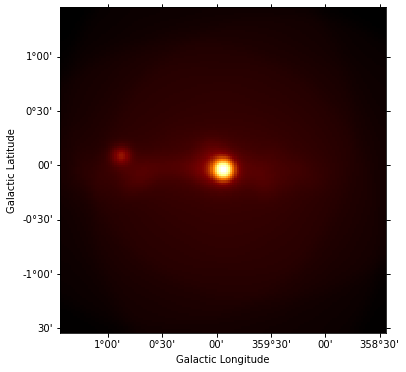

In [48]:
plt.figure(figsize=(6,6))
dataset_stacked.npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
#plt.plot((0,0), '*', color='black')
plt.savefig(pathtry/"model_tot_map.pdf")

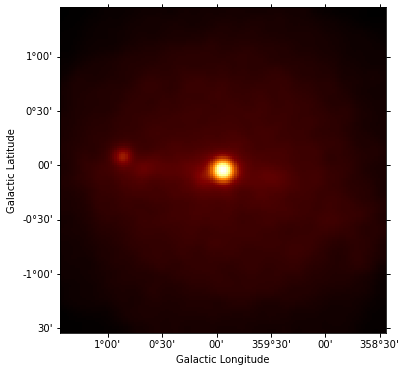

In [49]:
plt.figure(figsize=(6,6))
dataset_stacked.counts.sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
#plt.plot((0,0), '*', color='black')
plt.savefig(pathtry/"counts_total_map.pdf")

## Residuals

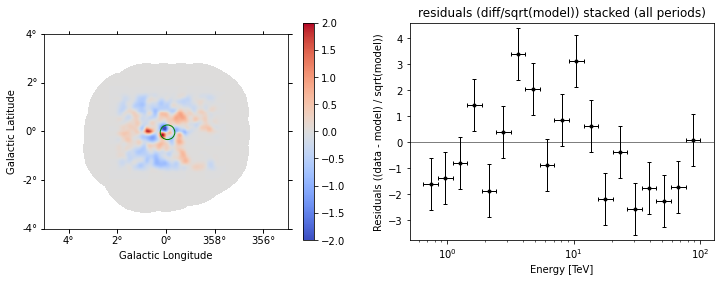

In [155]:
residuals(dataset_stacked,"stacked", "stacked (all periods)",vmax=2)

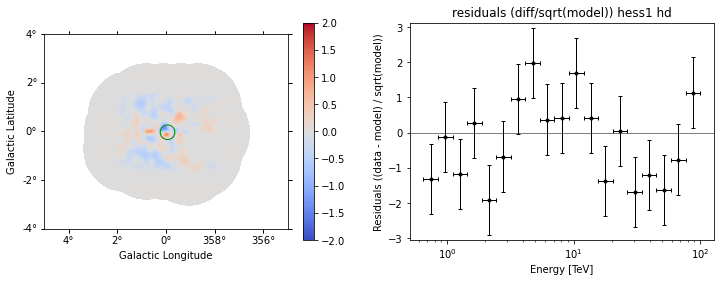

In [169]:
residuals(dataset_period['hess1'],"hess1", "hess1 hd",vmax=2)

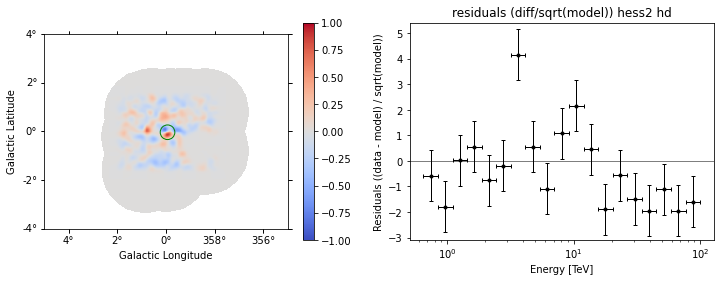

In [170]:
residuals(dataset_period['hess2'],"hess2", "hess2 hd",vmax=1)

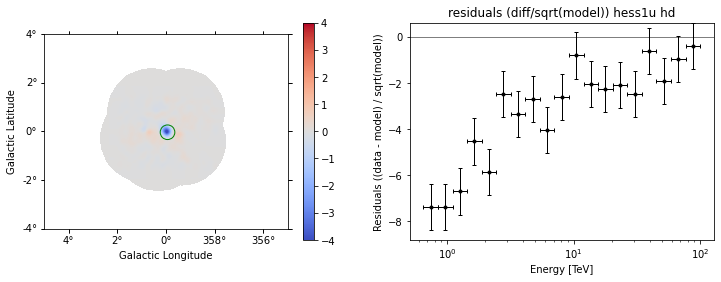

In [171]:
residuals(dataset_period['hess1u'],"hess1u", "hess1u hd",vmax=4)

## Significance map

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


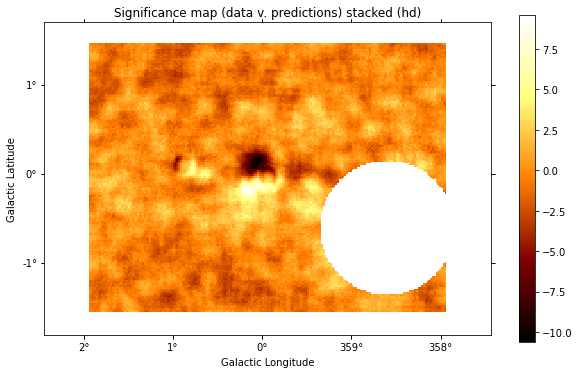

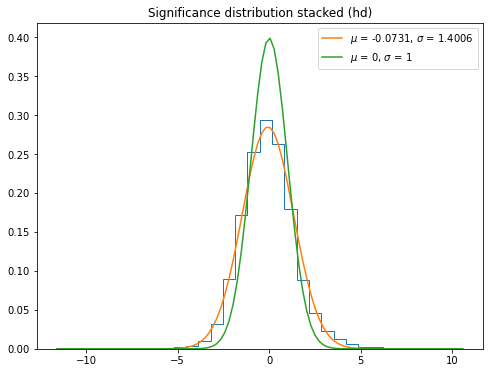

In [51]:
significance(dataset_stacked,"stacked", "stacked (hd)")

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


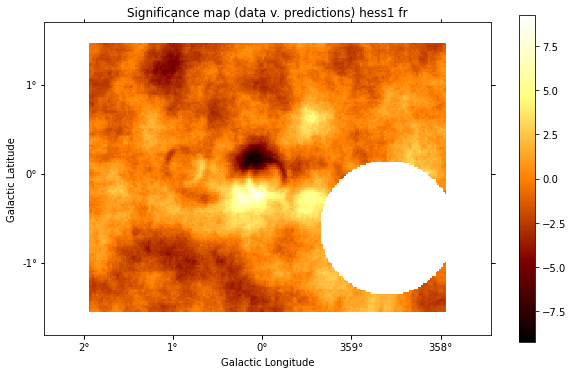

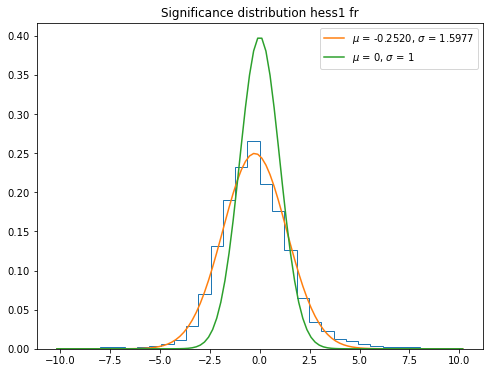

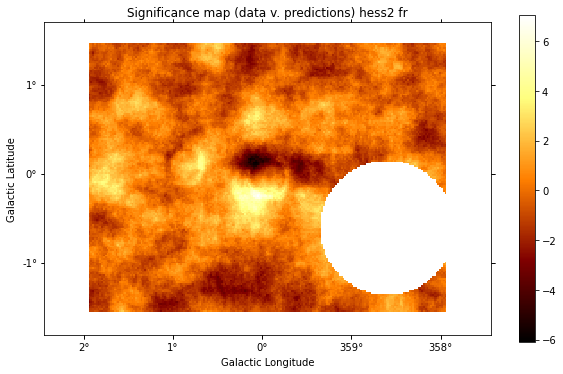

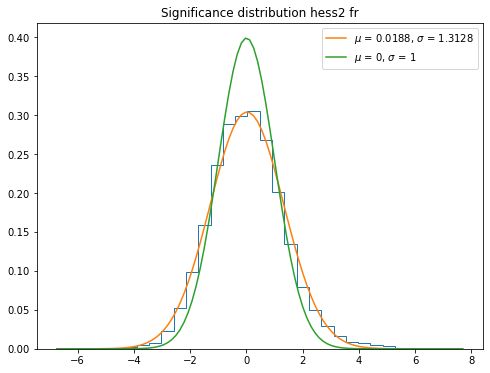

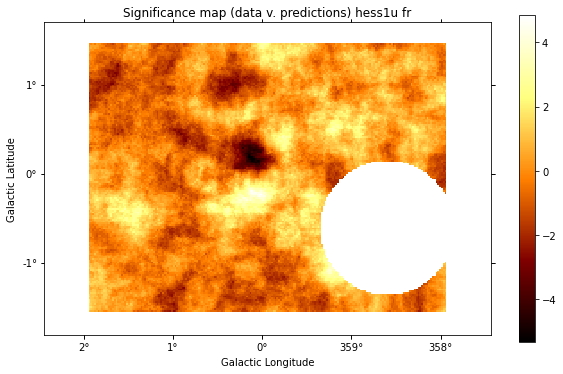

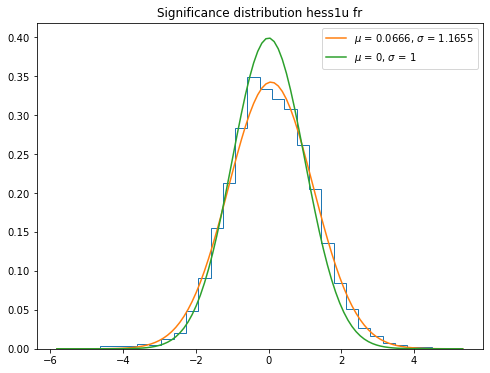

In [64]:
significance(dataset_period['hess1'],"hess1", "hess1 fr")
significance(dataset_period['hess2'],"hess2", "hess2 fr")
significance(dataset_period['hess1u'],"hess1u", "hess1u fr")

## Npred

In [85]:
dataset_period['hess1'].models[2].name

'sZhQFbHw'

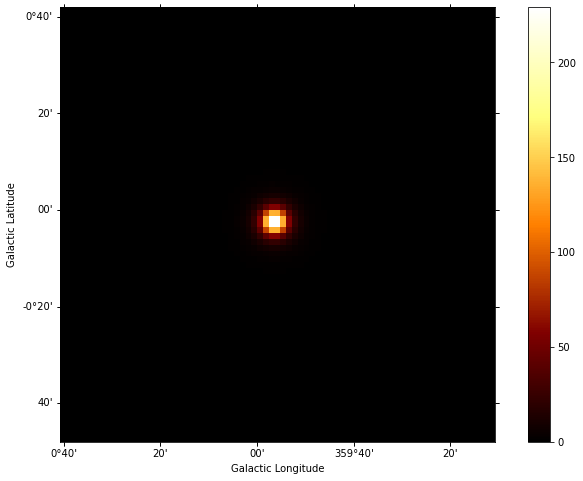

In [91]:
plt.figure(figsize=(12,8))
dataset_period['hess1'].npred_signal(model=dataset_period['hess1'].models[0]).sum_over_axes().cutout(position=src_pos, width=(3 * u.deg, 2* u.deg)).plot(add_cbar=True)
plt.savefig(pathtry/"npred_GC_hess1.png")

## Properly estimating the error on the parameter (using likelihood)

In [44]:
with open(pathtry/'errors.txt', "a") as out:
    out.write("")
    
dataset = dataset_period
models = models_joint
table = table_joint

In [50]:
%%time

param = models[0].spectral_model.parameters["index"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param.name, sigma=1)
    
    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "GC index = {0:03.3f}, errp = {1:03.3f}, errn = {2:03.3f}, err_naive = {3:03.3f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][2]
            )  + "\n"
        )

CPU times: user 2min 13s, sys: 2.42 s, total: 2min 16s
Wall time: 2min 16s


In [51]:
%%time

param = models[2].spectral_model.parameters["index"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param.name, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "DE index = {0:03.3f}, errp = {1:03.3f}, errn = {2:03.3f}, err_naive = {3:03.3f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][13]
            )  + "\n"
        )

CPU times: user 1min 57s, sys: 1.91 s, total: 1min 59s
Wall time: 1min 59s


In [52]:
%%time

param = models[0].spectral_model.parameters["lambda_"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param.name, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "GC lambda = {0:03.4f}, errp = {1:03.4f}, errn = {2:03.4f}, err_naive = {3:03.4f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][5]
            )  + "\n"
        )

CPU times: user 1min 54s, sys: 1.86 s, total: 1min 56s
Wall time: 1min 56s


In [53]:
%%time

param = models[2].spectral_model.parameters["lambda_"]

if param.frozen == False:
    
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param.name, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "DE lambda = {0:03.4f}, errp = {1:03.4f}, errn = {2:03.4f}, err_naive = {3:03.4f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][16]
            )  + "\n"
        )

CPU times: user 1min 57s, sys: 1.87 s, total: 1min 59s
Wall time: 1min 59s


In [54]:
param = models[0].spectral_model.parameters["amplitude"]

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "GC ampli = {0:03.4e}, err_naive = {1:03.4e}".format(
            param.value, table['error'][3]
        )  + "\n"
    )


param = models[2].spectral_model.parameters["amplitude"]

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "DE ampli = {0:03.4e}, err_naive = {1:03.4e}".format(
            param.value, table['error'][14]
        )  + "\n"
    )

# Confidence contours

What will be interesting is how spectral indices and energy cutoffs are correlated, but we might want to see how parameters from different models are correlated too

In [113]:
from gammapy.visualization.utils import plot_contour_line
from itertools import combinations

def make_contours_old(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["index", "lambda_", "amplitude"], r=2):
            contour = fit.minos_contour(
                result.parameters[par_1],
                result.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour[par_1].tolist(),
                par_2: contour[par_2].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma



def make_contours(fit, result, models, npoints, sigmas):
    
    indexGC = [models[0].spectral_model.parameters['index'], 'indexGC']
    indexDE = [models[2].spectral_model.parameters['index'], 'indexDE']
    lambdaGC = [models[0].spectral_model.parameters['lambda_'], 'lambdaGC']
    lambdaDE = [models[2].spectral_model.parameters['lambda_'], 'lambdaDE']
    params = [indexGC, indexDE, lambdaGC, lambdaDE] 
    
    # on ne peut pas renseigner les paramètres comme ça
                
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(params, r=2):
            contour = fit.minos_contour(
                par_1[0],
                par_2[0],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1[1]}_{par_2[1]}"] = {
                par_1[1] : contour[par_1[0]].tolist(),
                par_2[1] : contour[par_2[0]].tolist(),
                }
        cts_sigma.append(contours)
    return cts_sigma

In [115]:
%%time

# different parameters with the same name

sigma = [1, 2]
cts_sigma = make_contours(fit_joint, result_joint, models_joint, 10, sigma)

ValueError: Parameter(name='index', value=1.9810166196850483, factor=1.9810166196850483, scale=1.0, unit=Unit(dimensionless), min=nan, max=nan, frozen=False, id=0x7fb923c3ba58) is not in list

In [73]:
result.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,1.9075e+00,,nan,nan,False,4.488e-02
amplitude,2.2257e-12,cm-2 s-1 TeV-1,nan,nan,False,4.994e-14
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
lambda_,1.2075e-01,TeV-1,nan,nan,False,1.346e-02
alpha,1.0000e+00,,nan,nan,True,0.000e+00
lon_0,3.5994e+02,deg,nan,nan,True,0.000e+00
lat_0,-4.0000e-02,deg,-9.000e+01,9.000e+01,True,0.000e+00
index,2.3000e+00,,nan,nan,True,0.000e+00
amplitude,6.2399e-13,cm-2 s-1 TeV-1,nan,nan,False,2.130e-14


In [88]:
pars = {
    "phi": r"$\phi_0 \,/\,(10^{-12}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "index": r"$\Gamma$",
    "lambda": r"$\lambda$",
}


panels = [
    {
        "x": "index",
        "y": "phi",
        "cx": (lambda ct: ct["contour_index_amplitude"]["index"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_index_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "lambda",
        "y": "phi",
        "cx": (lambda ct: ct["contour_lambda__amplitude"]["lambda_"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_lambda__amplitude"]["amplitude"]
        ),
    },
    {
        "x": "index",
        "y": "lambda",
        "cx": (lambda ct: ct["contour_index_lambda_"]["index"]),
        "cy": (lambda ct: ct["contour_index_lambda_"]["lambda_"]),
    },
]

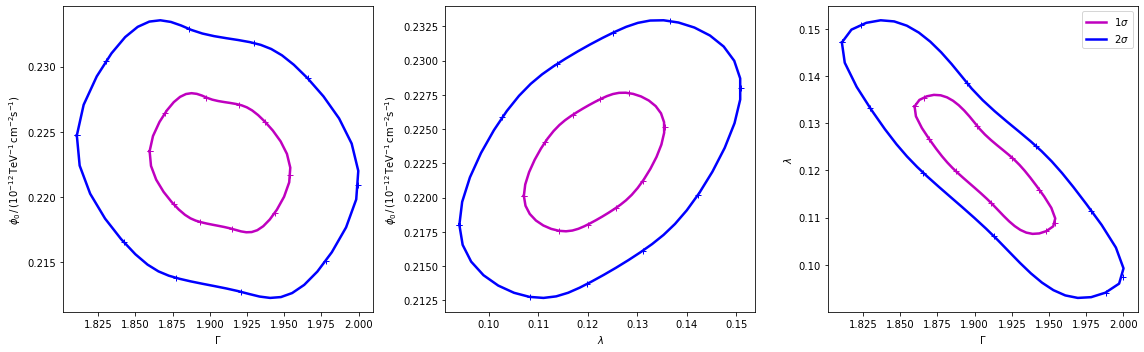

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(
            ax,
            p["cx"](cts_sigma[ks]),
            p["cy"](cts_sigma[ks]),
            lw=2.5,
            color=colors[ks],
            label=f"{sigma[ks]}" + r"$\sigma$",
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()
plt.savefig(pathtry/"contours_GCspectrum_joint_hd.pdf")


In [63]:
cts_sigma

[{'contour_index_lambda_': {'index': [1.8597210839595537,
    1.8696585334358669,
    1.8876614581553253,
    1.9111955056091212,
    1.948147899254635,
    1.9543075502792404,
    1.9437763590636494,
    1.925400791314599,
    1.902024145746469,
    1.8658913629911076],
   'lambda_': [0.13347060776678152,
    0.1264876027034871,
    0.11966786401711549,
    0.1129899875330215,
    0.10695030589645652,
    0.10874932858207419,
    0.11573556022502847,
    0.12255757441089832,
    0.1292498153822148,
    0.13534858451228401]},
  'contour_index_amplitude': {'index': [1.8597210839595537,
    1.8758385934468889,
    1.893547417018886,
    1.9152368142990226,
    1.9437152710350794,
    1.9543075502792404,
    1.9375095031754797,
    1.9195934176871645,
    1.8978144817283953,
    1.8698166086678778],
   'amplitude': [2.2356054145774417e-12,
    2.1949779827752668e-12,
    2.1813721845206425e-12,
    2.17605332899769e-12,
    2.188192247375731e-12,
    2.217281411300978e-12,
    2.257885254